# OpenCV inpainting

Adapted from: https://pyimagesearch.com/2020/05/18/image-inpainting-with-opencv-and-python/?utm_source=chatgpt.com

In [10]:
## Import libraries
# system
import os
import time
import sys
import argparse

# machine learning
import cv2

# data manipulation
import yaml
import xarray as xr
import dask
import numpy as np
# dask friendliness for large rasters
dask.config.set({"array.slicing.split_large_chunks": True})

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

###### setup config variables #######
repo_name = 'masterthesis_genai_spatialplan'
if not repo_name in os.getcwd():
    os.chdir(repo_name)

p=os.popen('git rev-parse --show-toplevel')
repo_dir = p.read().strip()
p.close()

# Import helper functions
sys.path.append(f"{repo_dir}/code/helpers")
from get_region_filenames import get_region_filenames

with open(f"{repo_dir}/config.yml", 'r') as stream:
    config = yaml.safe_load(stream)

regions = config['regions'] 

big_data_storage_path = config.get("big_data_storage_path", "/work/zt75vipu-master/data")
region_filenames_json = get_region_filenames(config_path=f"{repo_dir}/config.yml")
print("Region filenames JSON loaded successfully: ", region_filenames_json)

#seaborn cmap
rocket=sns.color_palette("rocket", as_cmap=True)
mako=sns.color_palette("mako", as_cmap=True)

Getting region filenames from config...
Regions to process: ['Dresden', 'Leipzig', 'Hamburg', 'Stuttgart']
Region filenames JSON loaded successfully:  {'Dresden': {'landsat_zarr_name': 'D:/master_thesis/data/landsat/dresden/landsat_temperature_ge25_cc10_2019_2024.zarr', 'osm_zarr_name': 'D:/master_thesis/data/osm/dresden/osm_rasterized.zarr', 'planet_zarr_name': 'D:/master_thesis/data/planet_scope/dresden/planet_config_ge25_cc10_2019_2024.zarr', 'processed_zarr_name': 'D:/master_thesis/data/processed/dresden/input_config_ge25_cc10_2019_2024.zarr'}, 'Leipzig': {'landsat_zarr_name': 'D:/master_thesis/data/landsat/leipzig/landsat_temperature_ge25_cc10_2019_2024.zarr', 'osm_zarr_name': 'D:/master_thesis/data/osm/leipzig/osm_rasterized.zarr', 'planet_zarr_name': 'D:/master_thesis/data/planet_scope/leipzig/planet_config_ge25_cc10_2019_2024.zarr', 'processed_zarr_name': 'D:/master_thesis/data/processed/leipzig/input_config_ge25_cc10_2019_2024.zarr'}, 'Hamburg': {'landsat_zarr_name': 'D:/maste

In [11]:
processed_zarr_name = region_filenames_json[regions[1]]['processed_zarr_name']
merged_xs = xr.open_zarr(processed_zarr_name, consolidated=True)

processed_zarr_name_clipped = processed_zarr_name.replace(".zarr", "_clipped.zarr")
merged_xs_clipped = xr.open_zarr(processed_zarr_name_clipped, consolidated=True)

In [99]:
merged_xs_clipped

<xarray.Dataset> Size: 4GB
Dimensions:                          (y: 5580, x: 6206, time: 4, channel: 4)
Coordinates:
  * channel                          (channel) <U5 80B 'blue' 'green' ... 'nir'
    spatial_ref                      int64 8B ...
  * time                             (time) datetime64[ns] 32B 2019-06-24T10:...
  * y                                (y) float64 45kB 5.699e+06 ... 5.682e+06
  * x                                (x) float64 50kB 3.078e+05 ... 3.264e+05
Data variables:
    buildings_service                (y, x) float32 139MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    landsat_surface_temp_b10_masked  (time, y, x) float32 554MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    ndvi                             (time, y, x) float32 554MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    streets                          (y, x) float32 139MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    buildings_heights                (y, x) float32 139MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    buildings                        (y, x) float32 139MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    landuse                          (y, x) float32 139MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    planetscope_sr_4band             (time, channel, y, x) float32 2GB dask.array<chunksize=(1, 4, 1024, 1024), meta=np.ndarray>
    streets_service                  (y, x) float32 139MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    streets_surface                  (y, x) float32 139MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    water                            (y, x) float32 139MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>

In [91]:
# dataset class that returns NumPy arrays
class PatchNumpyDataset():
    def __init__(self, input_xs, patch_size=192, stride=192, min_valid_percent=90):
        
        # select RGB channels
        self.img_da = input_xs['planetscope_sr_4band'].sel(channel=['red', 'green', 'blue'])
        self.patch_size = patch_size
        self.stride = stride

        # Pre-compute validity mask
        print("Computing validity mask...")
        valid_mask = (~self.img_da.isnull()).all(dim='channel').values  # (H, W) boolean array
        
        # calculate patch indices
        self.patches = []
        H, W = self.img_da.shape[1:]
        min_valid_pixels = int((patch_size * patch_size) * (min_valid_percent / 100))
        
        for y in range(0, H - patch_size + 1, stride):
            for x in range(0, W - patch_size + 1, stride):
                # count valid pixels
                valid_count = valid_mask[y:y+patch_size, x:x+patch_size].sum()
                
                if valid_count >= min_valid_pixels:
                    self.patches.append((y, x))
        
        print(f"Found {len(self.patches)} from a total of {((H - patch_size) // stride + 1) * ((W - patch_size) // stride + 1)} patches with at least {min_valid_percent}% valid data.")
        
        # convert to numpy
        self.img = self.img_da.values


    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        y, x = self.patches[idx]
        # get patch and transpose from (C, H, W) to (H, W, C) for OpenCV
        img_patch = self.img[:, y:y+self.patch_size, x:x+self.patch_size].transpose(1, 2, 0)
        
        # fill nans with -9999
        img_patch = np.nan_to_num(img_patch, nan=-9999)
        
        # normalize image to [0, 255] and convert to uint8
        img_patch_norm = (img_patch - img_patch.min()) / (img_patch.max() - img_patch.min() + 1e-6)
        img_patch_uint8 = (img_patch_norm * 255).astype(np.uint8)

        return img_patch_uint8


# patch  dataset parameters
resolution = 3 # resolution in meters
pixel_size = 600 # pixel size in meters
image_size = int(pixel_size / resolution)

# Adjust image size to be a multiple of 16
if image_size % 16 != 0:
    image_size = int(image_size / 16) * 16
    print(f"Image size adjusted to {image_size} to be a multiple of 16")
    

valid_planet_dates = (merged_xs['planetscope_sr_4band'].notnull().sum(dim=['x', 'y']) > 0).any(dim='channel').compute()
valid_planet_dates = merged_xs['time'].where(valid_planet_dates, drop=True).values

# create dataset
patch_dataset_np = PatchNumpyDataset(merged_xs_clipped.sel(time=valid_planet_dates[0]), patch_size=image_size, stride=image_size)

Image size adjusted to 192 to be a multiple of 16
Computing validity mask...
Found 615 from a total of 928 patches with at least 90% valid data.


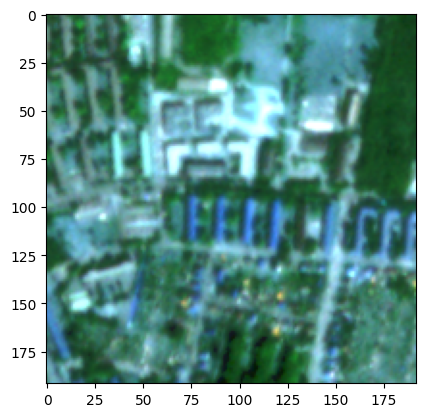

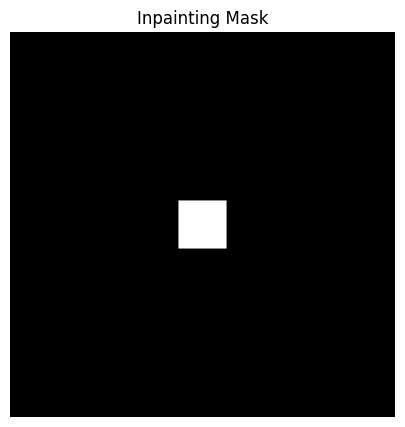

In [96]:
image_for_cv = patch_dataset_np[125] 

rgb = np.stack([
    image_for_cv[:, :, 2],
    image_for_cv[:, :, 1],
    image_for_cv[:, :, 0]
], axis=-1).astype(np.float32)

rgb = np.clip(rgb / np.nanpercentile(rgb, 98), 0, 1)
plt.imshow(rgb)
plt.show()
plt.close()

# create a mask cutting out the center of the image
mask = np.zeros(image_for_cv.shape[:2], dtype=np.uint8)
center = (image_for_cv.shape[1] // 2, image_for_cv.shape[0] // 2)
half_size = image_size // 15
mask[center[1]-half_size:center[1]+half_size, center[0]-half_size:center[0]+half_size] = 1

# plot for testing
plt.figure(figsize=(15, 5))
plt.imshow(mask, cmap='gray')
plt.title("Inpainting Mask")
plt.axis('off')
plt.show()
plt.close()

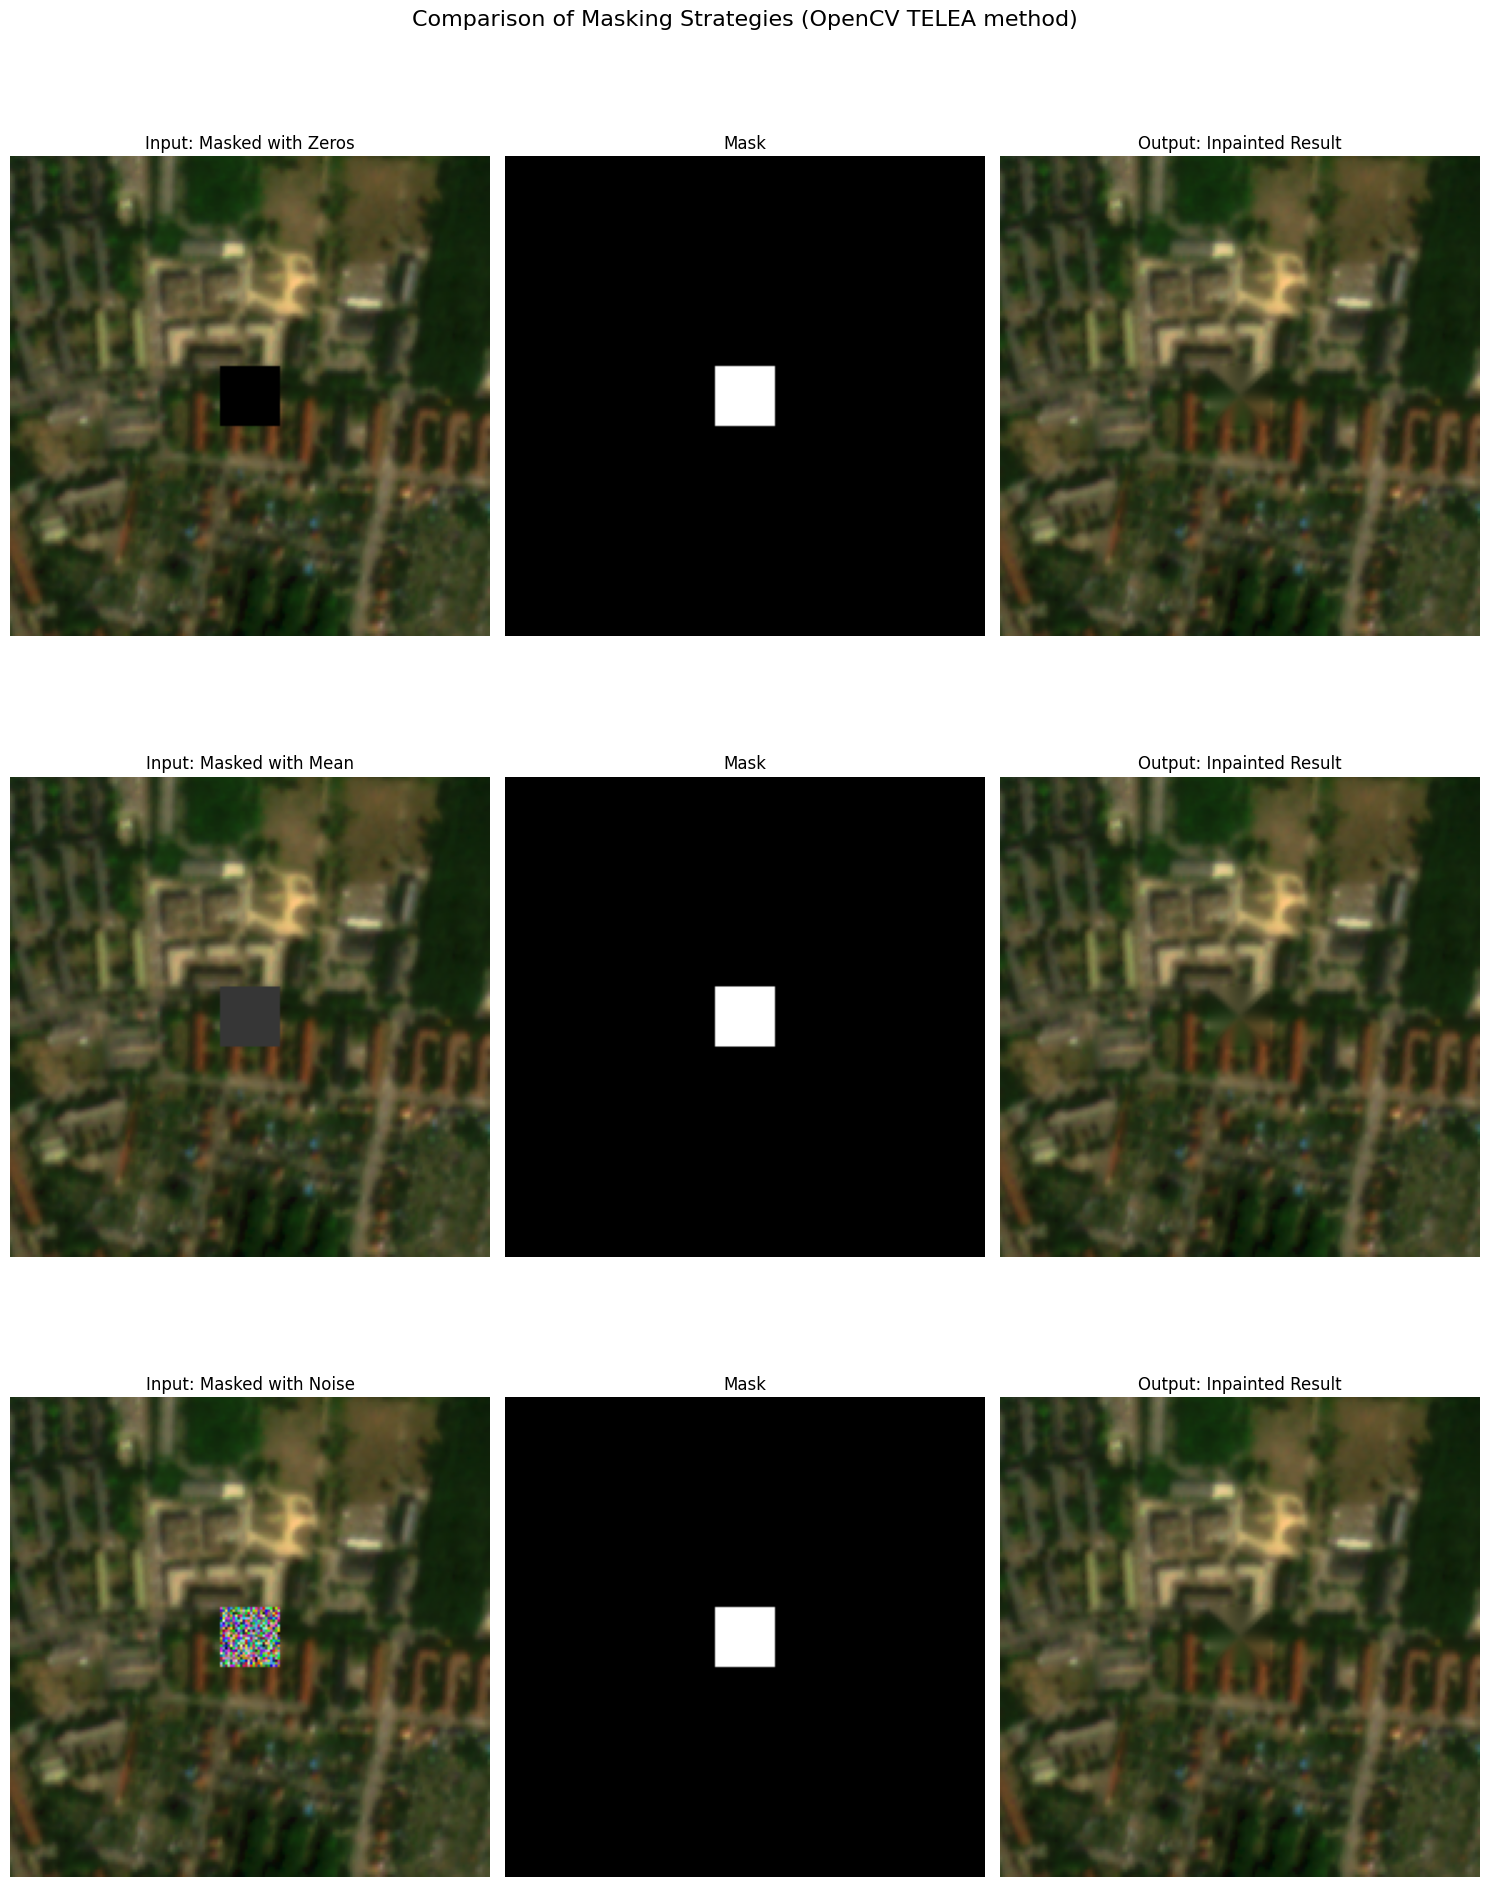

Original image shape: (192, 192, 3)
Number of masked pixels: 576
Percentage of image masked: 1.56%

MSE (Zeros): 408.7512
MSE (Mean): 408.7512
MSE (Noise): 408.7512


In [101]:
# --- inpainting parameters ---
inpainting_method = "telea" # or "ns"
inpainting_radius = 3

# openCV flag based on the chosen method
flags = cv2.INPAINT_TELEA
if inpainting_method == "ns":
    flags = cv2.INPAINT_NS

# --- setup masked images ---
image_masked_zeros = image_for_cv.copy()
image_masked_zeros[mask == 1] = 0

image_masked_mean = image_for_cv.copy()
mean_value = image_for_cv[mask == 0].mean()
image_masked_mean[mask == 1] = mean_value

# random noise between 0 and 255
image_masked_noise = image_for_cv.copy()
noise = np.random.randint(0, 256, size=image_masked_noise[mask == 1].shape, dtype=np.uint8)
image_masked_noise[mask == 1] = noise

# --- perform inpainting---
output_zeros = cv2.inpaint(image_masked_zeros, mask, inpainting_radius, flags=flags)
output_mean = cv2.inpaint(image_masked_mean, mask, inpainting_radius, flags=flags)
output_noise = cv2.inpaint(image_masked_noise, mask, inpainting_radius, flags=flags)

# --- display results ---
fig, axs = plt.subplots(3, 3, figsize=(15, 20))

# strategy 1: masked with Zeros
axs[0, 0].imshow(image_masked_zeros)
axs[0, 0].set_title("Input: Masked with Zeros")
axs[0, 0].axis('off')

axs[0, 1].imshow(mask, cmap='gray')
axs[0, 1].set_title("Mask")
axs[0, 1].axis('off')

axs[0, 2].imshow(output_zeros)
axs[0, 2].set_title("Output: Inpainted Result")
axs[0, 2].axis('off')

# strategy 2: masked with Mean
axs[1, 0].imshow(image_masked_mean)
axs[1, 0].set_title("Input: Masked with Mean")
axs[1, 0].axis('off')

axs[1, 1].imshow(mask, cmap='gray')
axs[1, 1].set_title("Mask")
axs[1, 1].axis('off')

axs[1, 2].imshow(output_mean)
axs[1, 2].set_title("Output: Inpainted Result")
axs[1, 2].axis('off')

# strategy 3: masked with Noise
axs[2, 0].imshow(image_masked_noise)
axs[2, 0].set_title("Input: Masked with Noise")
axs[2, 0].axis('off')

axs[2, 1].imshow(mask, cmap='gray')
axs[2, 1].set_title("Mask")
axs[2, 1].axis('off')

axs[2, 2].imshow(output_noise)
axs[2, 2].set_title("Output: Inpainted Result")
axs[2, 2].axis('off')

plt.suptitle(f"Comparison of Masking Strategies (OpenCV {inpainting_method.upper()} method)", 
             fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

# --- loss calculation ---
print(f"Original image shape: {image_for_cv.shape}")
print(f"Number of masked pixels: {np.sum(mask == 1)}")
print(f"Percentage of image masked: {100 * np.sum(mask == 1) / mask.size:.2f}%\n")

# loss for each strategy
strategies = {
    "Zeros": output_zeros,
    "Mean": output_mean,
    "Noise": output_noise
}

masked_pixels_original = image_for_cv[mask == 1].astype(np.float32)

for strategy_name, reconstructed in strategies.items():
    masked_pixels_reconstructed = reconstructed[mask == 1].astype(np.float32)
    mse_masked = np.mean((masked_pixels_original - masked_pixels_reconstructed) ** 2)
    print(f"MSE ({strategy_name}): {mse_masked:.4f}")

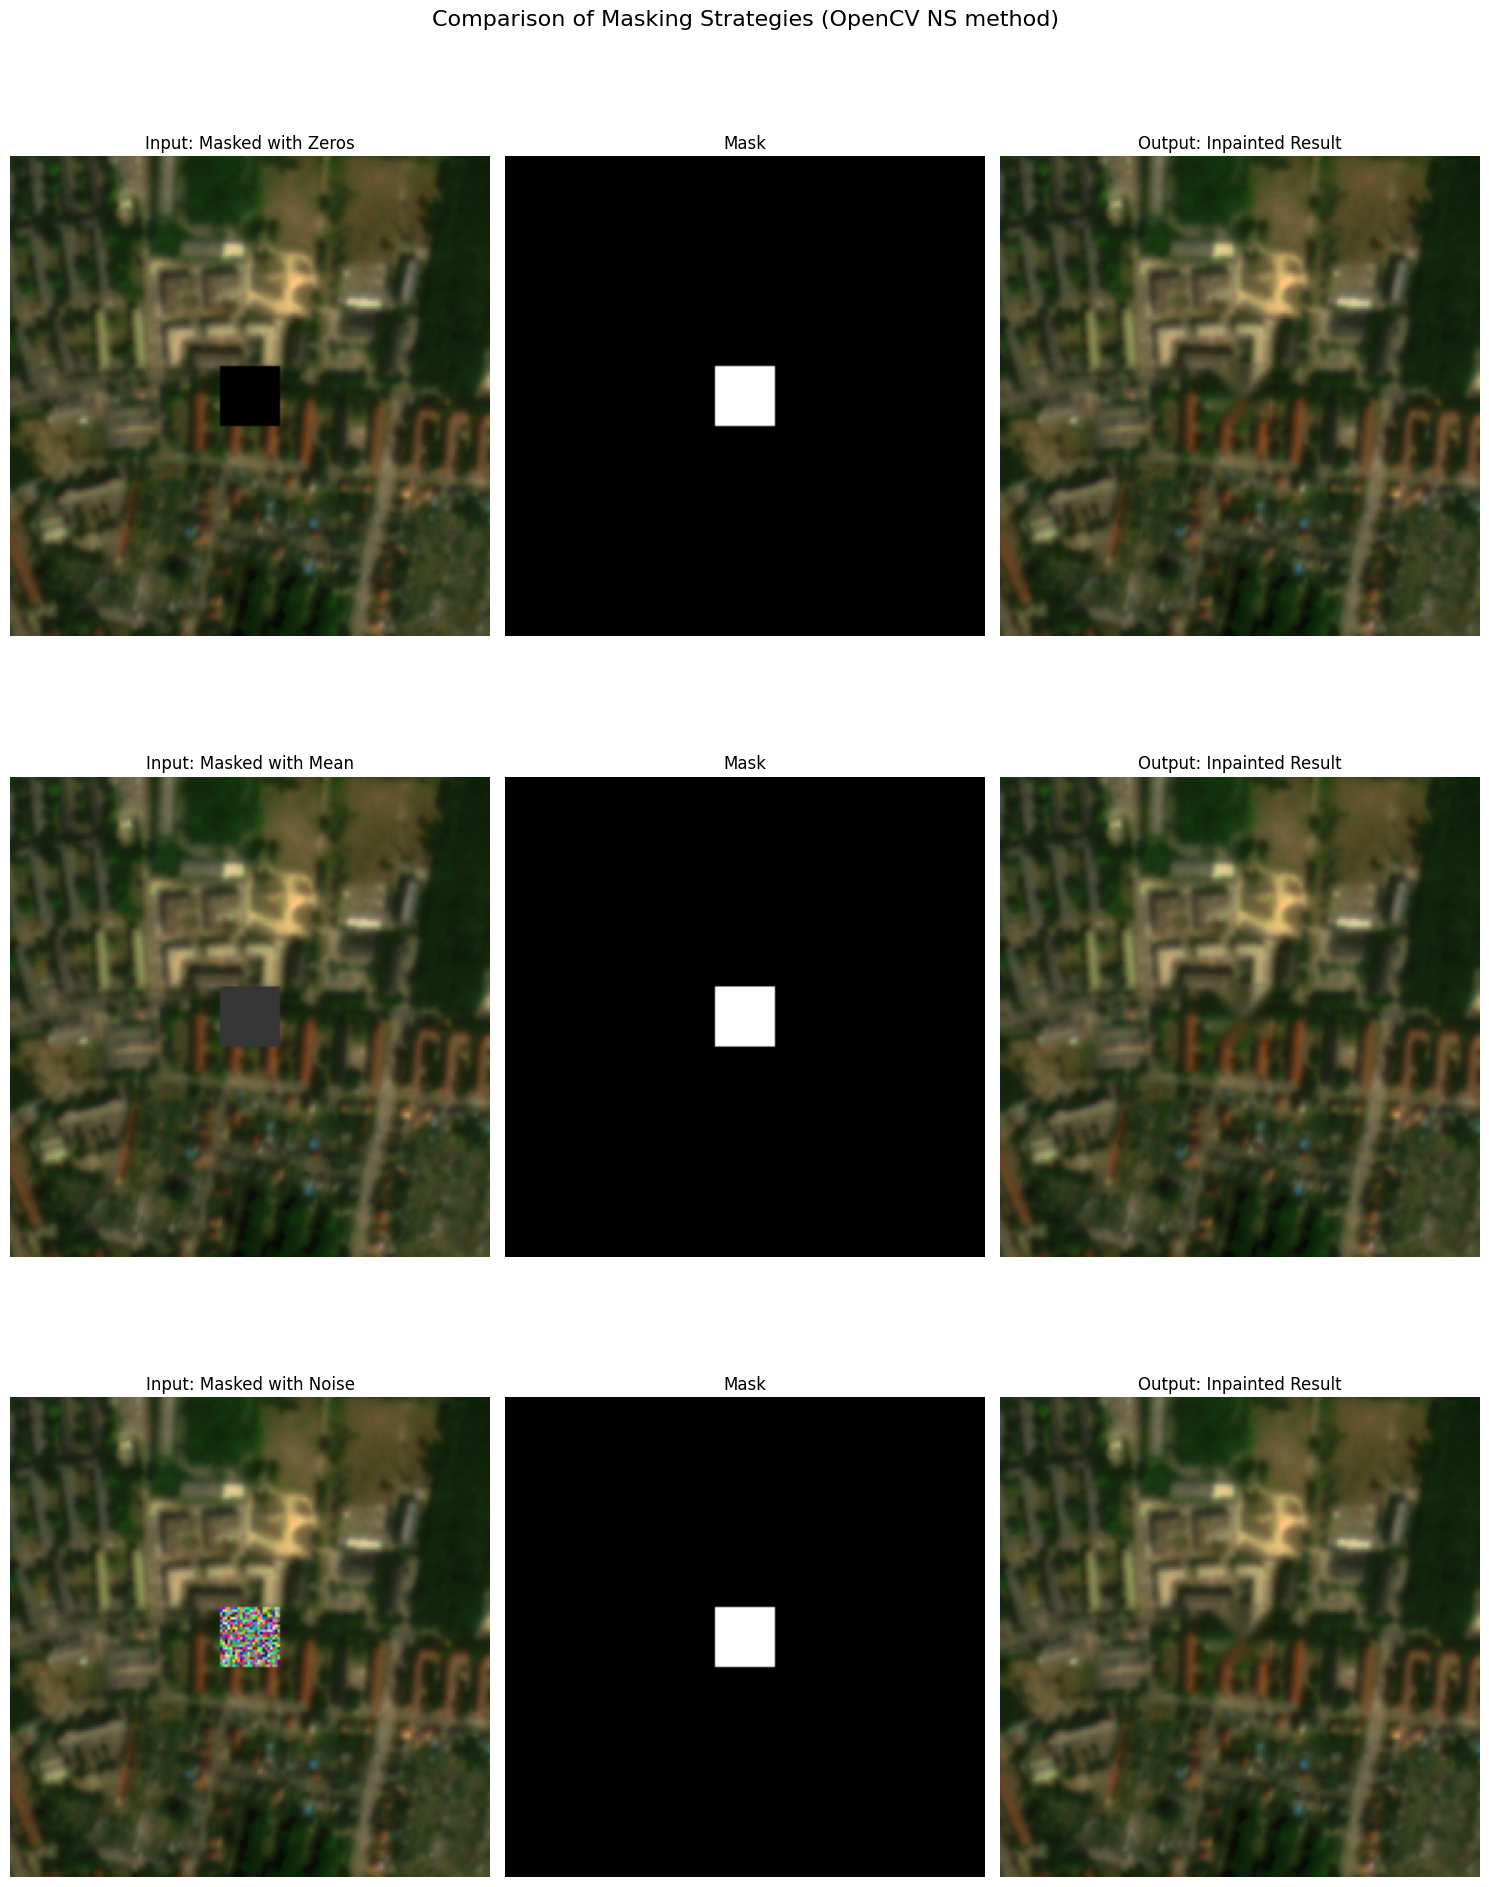

Original image shape: (192, 192, 3)
Number of masked pixels: 576
Percentage of image masked: 1.56%

MSE (Zeros): 462.5006
MSE (Mean): 462.5006
MSE (Noise): 462.5006


In [103]:
# --- inpainting parameters ---
inpainting_method = "ns" # or "telea"
inpainting_radius = 3

# openCV flag based on the chosen method
flags = cv2.INPAINT_TELEA
if inpainting_method == "ns":
    flags = cv2.INPAINT_NS

# --- setup masked images ---
image_masked_zeros = image_for_cv.copy()
image_masked_zeros[mask == 1] = 0

image_masked_mean = image_for_cv.copy()
mean_value = image_for_cv[mask == 0].mean()
image_masked_mean[mask == 1] = mean_value

# random noise between 0 and 255
image_masked_noise = image_for_cv.copy()
noise = np.random.randint(0, 256, size=image_masked_noise[mask == 1].shape, dtype=np.uint8)
image_masked_noise[mask == 1] = noise

# --- perform inpainting---
output_zeros = cv2.inpaint(image_masked_zeros, mask, inpainting_radius, flags=flags)
output_mean = cv2.inpaint(image_masked_mean, mask, inpainting_radius, flags=flags)
output_noise = cv2.inpaint(image_masked_noise, mask, inpainting_radius, flags=flags)

# --- display results ---
fig, axs = plt.subplots(3, 3, figsize=(15, 20))

# strategy 1: masked with Zeros
axs[0, 0].imshow(image_masked_zeros)
axs[0, 0].set_title("Input: Masked with Zeros")
axs[0, 0].axis('off')

axs[0, 1].imshow(mask, cmap='gray')
axs[0, 1].set_title("Mask")
axs[0, 1].axis('off')

axs[0, 2].imshow(output_zeros)
axs[0, 2].set_title("Output: Inpainted Result")
axs[0, 2].axis('off')

# strategy 2: masked with Mean
axs[1, 0].imshow(image_masked_mean)
axs[1, 0].set_title("Input: Masked with Mean")
axs[1, 0].axis('off')

axs[1, 1].imshow(mask, cmap='gray')
axs[1, 1].set_title("Mask")
axs[1, 1].axis('off')

axs[1, 2].imshow(output_mean)
axs[1, 2].set_title("Output: Inpainted Result")
axs[1, 2].axis('off')

# strategy 3: masked with Noise
axs[2, 0].imshow(image_masked_noise)
axs[2, 0].set_title("Input: Masked with Noise")
axs[2, 0].axis('off')

axs[2, 1].imshow(mask, cmap='gray')
axs[2, 1].set_title("Mask")
axs[2, 1].axis('off')

axs[2, 2].imshow(output_noise)
axs[2, 2].set_title("Output: Inpainted Result")
axs[2, 2].axis('off')

plt.suptitle(f"Comparison of Masking Strategies (OpenCV {inpainting_method.upper()} method)", 
             fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

# --- loss calculation ---
print(f"Original image shape: {image_for_cv.shape}")
print(f"Number of masked pixels: {np.sum(mask == 1)}")
print(f"Percentage of image masked: {100 * np.sum(mask == 1) / mask.size:.2f}%\n")

# loss for each strategy
strategies = {
    "Zeros": output_zeros,
    "Mean": output_mean,
    "Noise": output_noise
}

masked_pixels_original = image_for_cv[mask == 1].astype(np.float32)

for strategy_name, reconstructed in strategies.items():
    masked_pixels_reconstructed = reconstructed[mask == 1].astype(np.float32)
    mse_masked = np.mean((masked_pixels_original - masked_pixels_reconstructed) ** 2)
    print(f"MSE ({strategy_name}): {mse_masked:.4f}")